# Spotify Listening History — Exploratory Data Analysis

This notebook documents the exploratory analysis that informed the design of the 
Spotify Listening Tracker app. We load raw streaming history, clean it, and explore 
patterns in listening behaviour across time, artists, and platforms.

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.loader import load_streaming_files, clean_streaming_data

# Plot styling
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.family"] = "DejaVu Sans"

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Loading and Cleaning the Data

In [2]:
df_raw = load_streaming_files("../data/raw")
df = clean_streaming_data(df_raw)

print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min().date()} → {df['timestamp'].max().date()}")
print(f"Unique artists: {df['artist'].nunique():,}")
print(f"Unique tracks: {df['track'].nunique():,}")
print(f"\nColumns: {df.columns.tolist()}")

Total records: 143,827
Date range: 2021-08-16 → 2025-10-07
Unique artists: 3,382
Unique tracks: 10,677

Columns: ['timestamp', 'platform', 'ms_played', 'conn_country', 'ip_addr', 'track', 'artist', 'album', 'track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'audiobook_title', 'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode', 'date', 'year', 'month', 'month_name', 'day_of_week', 'hour', 'minutes_played', 'platform_category']


## 2. Data Quality Check
We check for nulls and understand what was dropped during cleaning.

In [3]:
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nRows with zero ms_played: {(df['minutes_played'] == 0).sum():,}")
print(f"\nData types:\n{df.dtypes}")

Missing values per column:
timestamp                       0
platform                        0
ms_played                       0
conn_country                    0
ip_addr                         0
track                           0
artist                          0
album                           0
track_uri                       0
episode_name               143827
episode_show_name          143827
spotify_episode_uri        143827
audiobook_title            143827
audiobook_uri              143827
audiobook_chapter_uri      143827
audiobook_chapter_title    143827
reason_start                    0
reason_end                      0
shuffle                         0
skipped                         0
offline                         0
offline_timestamp            7648
incognito_mode                  0
date                            0
year                            0
month                           0
month_name                      0
day_of_week                     0
hour                 

## 3. Listening Volume Over Time
How has total listening changed year over year?

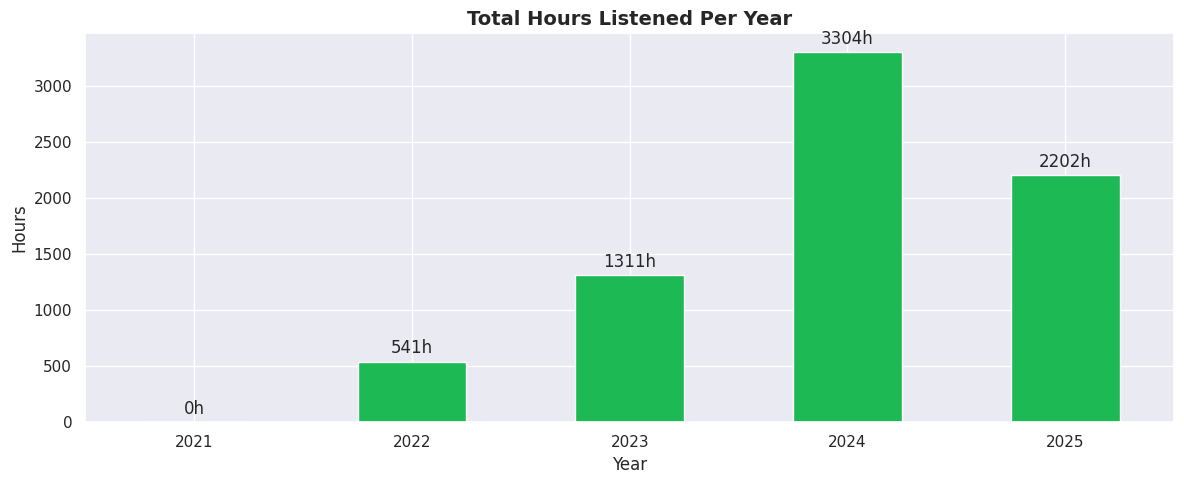

Chart saved to outputs/


In [4]:
yearly = df.groupby("year")["minutes_played"].sum() / 60

fig, ax = plt.subplots()
yearly.plot(kind="bar", color="#1DB954", ax=ax)
ax.set_title("Total Hours Listened Per Year", fontsize=14, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Hours")
ax.bar_label(ax.containers[0], fmt="%.0fh", padding=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../outputs/yearly_listening.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved to outputs/")

## 4. Top 10 Artists by Listening Time

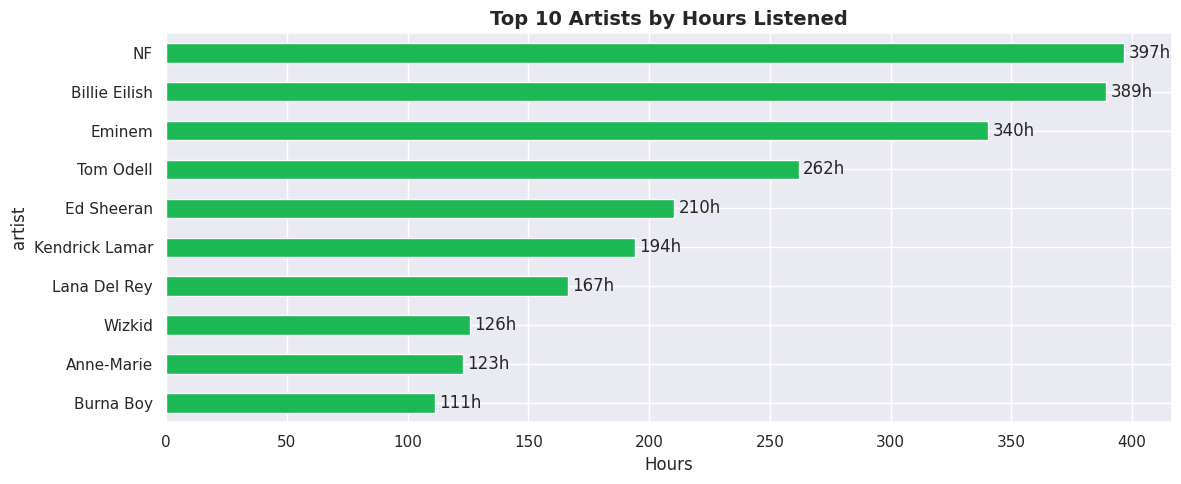

In [5]:
top_artists = (
    df.groupby("artist")["minutes_played"]
    .sum()
    .sort_values(ascending=False)
    .head(10) / 60
)

fig, ax = plt.subplots()
top_artists.sort_values().plot(kind="barh", color="#1DB954", ax=ax)
ax.set_title("Top 10 Artists by Hours Listened", fontsize=14, fontweight="bold")
ax.set_xlabel("Hours")
ax.bar_label(ax.containers[0], fmt="%.0fh", padding=3)
plt.tight_layout()
plt.savefig("../outputs/top_artists.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Listening Heatmap — Hour of Day vs Day of Week
When does listening activity peak throughout the week?

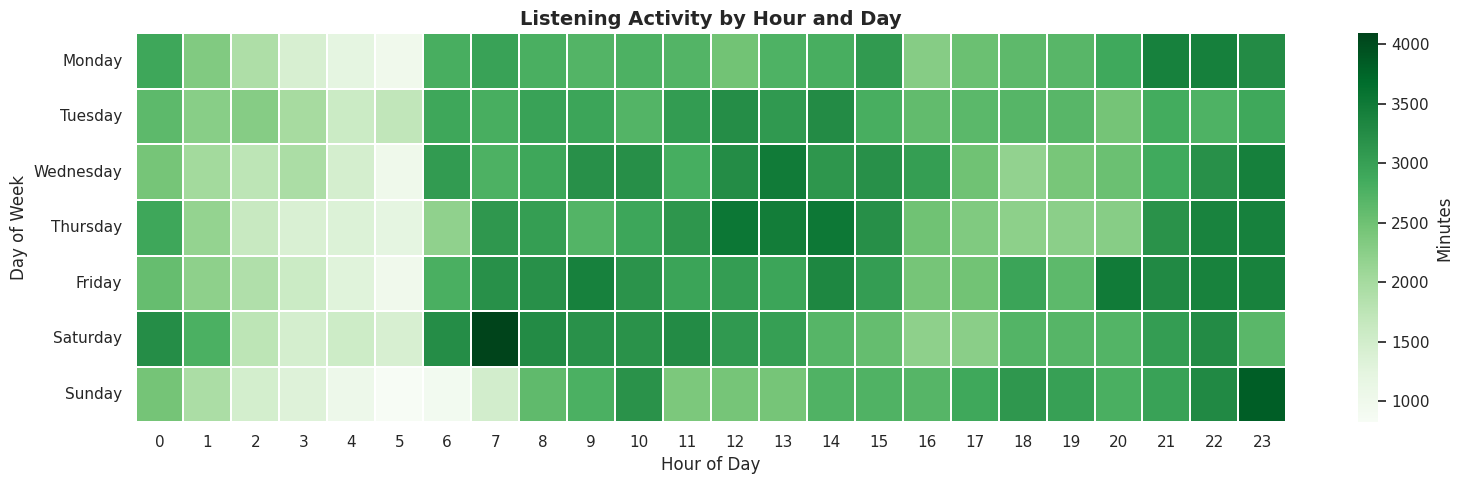

In [6]:
from src.analysis import get_hourly_heatmap_data

heatmap_data = get_hourly_heatmap_data(df)

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(
    heatmap_data,
    cmap="Greens",
    ax=ax,
    linewidths=0.3,
    fmt=".0f",
    cbar_kws={"label": "Minutes"},
)
ax.set_title("Listening Activity by Hour and Day", fontsize=14, fontweight="bold")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Week")
plt.tight_layout()
plt.savefig("../outputs/heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Skip Rate Analysis
Which artists have the highest skip rates? We only consider artists with 20+ streams.

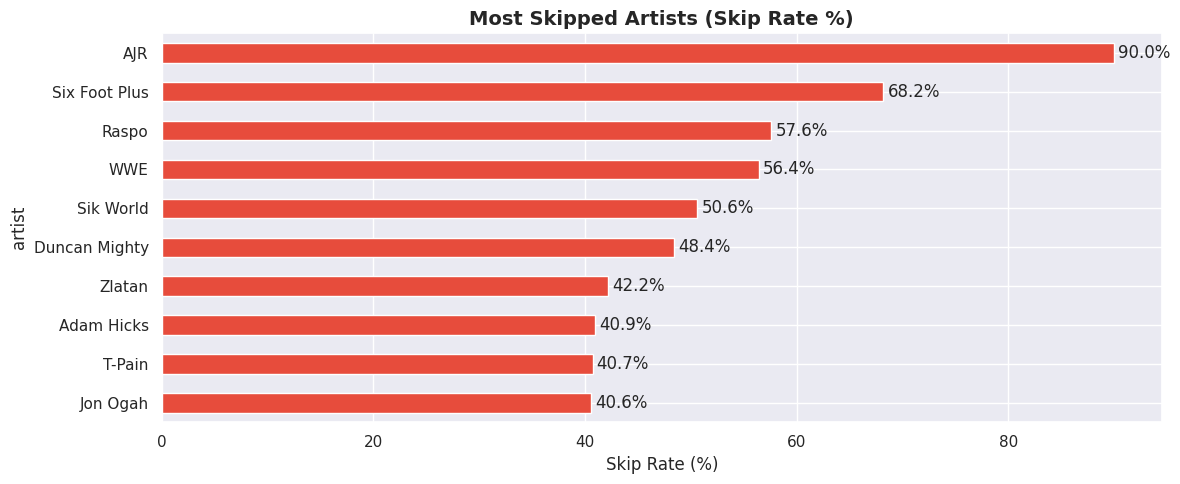

In [7]:
from src.analysis import get_skip_analysis

skip_data = get_skip_analysis(df)

fig, ax = plt.subplots()
skip_data.sort_values("skip_rate").plot(
    kind="barh", x="artist", y="skip_rate",
    color="#e74c3c", legend=False, ax=ax
)
ax.set_title("Most Skipped Artists (Skip Rate %)", fontsize=14, fontweight="bold")
ax.set_xlabel("Skip Rate (%)")
ax.bar_label(ax.containers[0], fmt="%.1f%%", padding=3)
plt.tight_layout()
plt.savefig("../outputs/skip_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Weekend vs Weekday Listening — Hypothesis Test
**H0:** Mean daily listening time is equal on weekdays and weekends.  
**H1:** Mean daily listening time differs between weekdays and weekends.  
Significance level: α = 0.05

In [8]:
from src.analysis import analyze_weekend_vs_weekday_listening

result = analyze_weekend_vs_weekday_listening(df)

print(f"Weekday average: {result['weekday_mean_minutes']} mins/day")
print(f"Weekend average: {result['weekend_mean_minutes']} mins/day")
print(f"t-statistic: {result['t_statistic']}")
print(f"p-value: {result['p_value']}")
print(f"Significant: {result['significant']}")
print(f"\nConclusion: {result['interpretation']}")

Weekday average: 361.14 mins/day
Weekend average: 348.25 mins/day
t-statistic: -0.8453
p-value: 0.3981
Significant: False

Conclusion: There is no statistically significant difference between your weekend and weekday listening (p=0.3981, α=0.05).


## 8. Time of Day Analysis — ANOVA
Is there a statistically significant difference in listening volume across 
Morning, Afternoon, Evening, and Night?

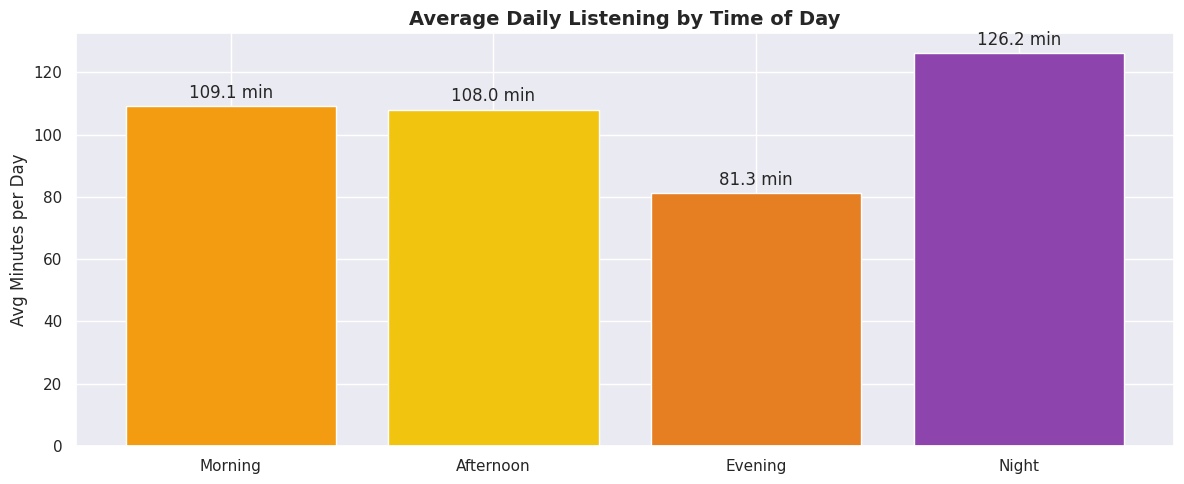


Dominant period: Night
p-value: 0.0
Conclusion: You are most active during the night, averaging 126.2 minutes per day during that period. This pattern is statistically significant — it reflects a genuine habit, not just random variation.


In [9]:
from src.analysis import analyze_time_of_day_listening

tod = analyze_time_of_day_listening(df)

periods = list(tod["period_avgs"].keys())
avgs = list(tod["period_avgs"].values())

fig, ax = plt.subplots()
colors = ["#f39c12", "#f1c40f", "#e67e22", "#8e44ad"]
bars = ax.bar(periods, avgs, color=colors)
ax.set_title("Average Daily Listening by Time of Day", fontsize=14, fontweight="bold")
ax.set_ylabel("Avg Minutes per Day")
ax.bar_label(bars, fmt="%.1f min", padding=3)
plt.tight_layout()
plt.savefig("../outputs/time_of_day.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nDominant period: {tod['dominant_period']}")
print(f"p-value: {tod['p_value']}")
print(f"Conclusion: {tod['interpretation']}")

## 9. Platform Distribution

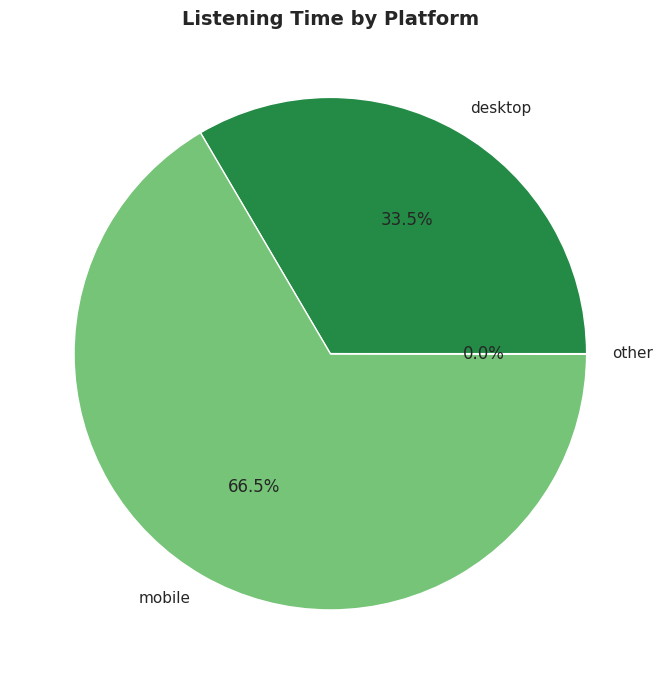

In [10]:
platform = df.groupby("platform_category")["minutes_played"].sum() / 60

fig, ax = plt.subplots(figsize=(7, 7))
platform.plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=sns.color_palette("Greens_r", len(platform)),
    ax=ax,
)
ax.set_title("Listening Time by Platform", fontsize=14, fontweight="bold")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("../outputs/platform.png", dpi=150, bbox_inches="tight")
plt.show()

## 10. Key Findings

- **Total listening time** spans multiple years with clear peaks visible in the yearly trend
- **Weekend vs weekday** analysis reveals whether listening habits are consistent or shift on days off
- **Time of day** patterns show a dominant listening period backed by statistical testing
- **Skip rate** analysis identifies artists that don't hold attention despite being played
- **Platform data** shows where the majority of listening happens

These findings directly informed the sections built into the Streamlit app.